## Setup

In [1]:
%matplotlib inline

# External modules
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action = "ignore")

# Path management
import os
from pathlib import Path

# Get main project directory 
main_dir = str(Path(os.path.abspath('')).parents[0])
os.chdir(main_dir)
print('main dir:',main_dir)

main dir: /Users/pablo/OneDrive/data-science/github/isuelogit


In [2]:
# Internal modules
from src import isuelogit as isl

### Read network data from Fresno

In [3]:
network_name = 'Fresno'

# Reader of geospatial and spatio-temporal data
data_reader = isl.etl.DataReader(network_key=network_name,setup_spark=True)

# Read files
links_df, nodes_df = isl.reader.read_fresno_network(folderpath=isl.dirs['Fresno_network'])

nodes_df.to_csv(isl.dirs['output_folder'] + '/network-data/nodes/'  + 'fresno-nodes-data.csv',
                sep=',', encoding='utf-8', index=False, float_format='%.3f')

# Add link key in dataframe
links_df['link_key'] = [(int(i), int(j), '0') for i, j in zip(links_df['init_node_key'], links_df['term_node_key'])]

22/04/12 15:28:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Build network

In [4]:
network_generator = isl.factory.NetworkGenerator()

A = network_generator.generate_adjacency_matrix(links_keys=list(links_df.link_key.values))

fresno_network = \
    network_generator.build_fresno_network(A=A, links_df=links_df, nodes_df=nodes_df, network_name= network_name)


Creating Fresno network

Nodes: 1789, Links: 2413


### Generate exogenous link features

In [5]:
# Extract data on link features from network file
link_features_df = links_df[['link_key', 'id', 'link_type', 'rhoj', 'lane', 'ff_speed', 'length']]

# Attributes
link_features_df['link_type'] = link_features_df['link_type'].apply(lambda x: x.strip())
link_features_df['rhoj'] = pd.to_numeric(link_features_df['rhoj'], errors='coerce', downcast='float')
link_features_df['lane'] = pd.to_numeric(link_features_df['lane'], errors='coerce', downcast='integer')
link_features_df['length'] = pd.to_numeric(link_features_df['length'], errors='coerce', downcast='float')

# Load features data
fresno_network.load_features_data(linkdata=link_features_df, link_key = 'link_key')

### Load link performance functions

In [6]:
options = {'tt_units': 'minutes'}

# Create two new features
if options['tt_units'] == 'minutes':
    # Weighting by 60 will leave travel time with minutes units, because speeds are originally in per hour units
    tt_factor = 60

if options['tt_units'] == 'seconds':
    tt_factor = 60 * 60

links_df['ff_speed'] = pd.to_numeric(links_df['ff_speed'], errors='coerce', downcast='float')
links_df['ff_traveltime'] = tt_factor * links_df['length'] / links_df['ff_speed']

bpr_parameters_df = pd.DataFrame({'link_key': links_df['link_key'],
                                  'alpha': 0.15,
                                  'beta': 4,
                                  'tf': links_df['ff_traveltime'],
                                  'k': pd.to_numeric(links_df['capacity'], errors='coerce', downcast='float')
                                  })

fresno_network.set_bpr_functions(bprdata=bpr_parameters_df, link_key = 'link_key')

### Read and write OD Matrix

In [7]:
# - Periods (4 periods of 15 minutes each)
data_reader.options['od_periods'] = [1, 2, 3, 4]

# Read OD from raw data
Q = isl.reader.read_fresno_dynamic_od(network=fresno_network,
                                  filepath=isl.dirs['Fresno_network'] + '/SR41.dmd',
                                  periods=data_reader.options['od_periods'])

network_generator.write_OD_matrix(network = fresno_network, sparse = True, overwrite_input=False)

Matrix Q (1789, 1789) read in 0.4[s]
66266.3 trips were loaded among 6970 o-d pairs
Matrix Q (1789, 1789) written in 0.0[s] with sparse format


## Processing of spatiotemporal and traffic count datasets

In [8]:
# 2019-10-01: First Tuesday of October, 2019
# 2020-10-06: First Tuesday of October, 2020
dates = ['2019-10-01','2020-10-06']

lwrlk_only = True

for date in dates:

    data_reader.select_period(date=date, hour=16)

    # =============================================================================
    # SPATIO-TEMPORAL LINK FEATURES
    # =============================================================================

    spatiotemporal_features_df, spatiotemporal_features_list = data_reader.read_spatiotemporal_data_fresno(
        lwrlk_only=True,
        read_inrix_selected_date_data = False, #When false, it is read all data from October 2019 and 2020. When true, only data from selected date is read
        network=fresno_network,
        selected_period_incidents={'year': [data_reader.options['selected_year']],},
                                   #'month': [1,2,3,4,5,6,7,8,9,10]},
                                   # 'day_month': [data_reader.options['selected_day_month']]},
        selected_period_inrix = {'year': [data_reader.options['selected_year']],
                                 'month': [data_reader.options['selected_month']],
                                 # 'day_month': [data_reader.options['selected_day_month']],
                                 'day_week': [1, 2, 3, 4, 5],
                                 'hour': data_reader.options['selected_hour']},
        buffer_size={'inrix': 100, 'bus_stops': 50, 'incidents': 50, 'streets_intersections': 50},
        tt_units= options['tt_units']
    )

    filepath = isl.dirs['output_folder'] + '/network-data/links/' + str(data_reader.options['selected_date']) \
           + '-fresno-spatiotemporal-link-data.csv'

    spatiotemporal_features_df.to_csv(filepath, sep=',', encoding='utf-8', index=False, float_format='%.3f')

    # Test Reader
    spatiotemporal_features_df = pd.read_csv(filepath)

    fresno_network.load_features_data(spatiotemporal_features_df)

    # =============================================================================
    # d) FREE FLOW TRAVEL TIME FROM INRIX
    # =============================================================================

    for link in fresno_network.links:
        if link.link_type == 'LWRLK' and link.Z_dict['speed_max']!=0:
            # Multiplied by 60 so speeds are in minutes
            link.Z_dict['tf_inrix'] = tt_factor * link.Z_dict['length'] / link.Z_dict['speed_max']
#             link.bpr.tf = tt_factor * link.Z_dict['length'] / link.Z_dict['speed_ref_avg']
        else:
            link.Z_dict['tf_inrix'] = link.bpr.tf 
            #= links_df[links_df['link_key'].astype(str) == str(link.key)]['ff_traveltime']

    # =============================================================================
    # 3c) DATA CURATION
    # =============================================================================

    # a) Imputation to correct for outliers and observations with zero values because no GIS matching

    features_list = ['median_inc', 'intersections', 'incidents', 'bus_stops', 'median_age',
                     'tt_avg', 'tt_sd','tt_var', 'tt_cv',
                     'speed_ref_avg', 'speed_hist_avg', 'speed_avg','speed_sd','speed_cv']

    for feature in features_list:
        fresno_network.link_data.feature_imputation(feature =feature, pcts = (0, 100),lwrlk_only=lwrlk_only)

    # b) Feature values in "connectors" links
    for key in features_list:
        for link in fresno_network.get_non_regular_links():
            link.Z_dict[key] = 0
    print('\nFeatures values of link with types different than "LWRLK" were set to 0')

    # a) Capacity adjustment

    # counts = isl.etl.adjust_counts_by_link_capacity(network = fresno_network, counts = counts)

    # b) Outliers

    # isl.etl.remove_outliers_fresno(fresno_network)

    # =============================================================================
    # 2.2) TRAFFIC COUNTS
    # =============================================================================

    # ii) Read data from PEMS count and perform matching GIS operations to combine station shapefiles

    date_pathname = data_reader.options['selected_date'].replace('-', '_')

    path_pems_counts = isl.dirs['input_folder'] + 'public/pems/counts/data/' + \
                       'd06_text_station_5min_' + date_pathname + '.txt.gz'

    # Read and match count data from a given period
    count_interval_df \
        = data_reader.read_pems_counts_by_period(
        filepath=path_pems_counts,
        selected_period={'hour': data_reader.options['selected_hour'],
                         'duration': int(len(data_reader.options['od_periods']) * 15)})

    # Generate a masked vector that fill out count values with no observations with nan
    counts = isl.etl.generate_fresno_pems_counts(links=fresno_network.links
                                                 , data=count_interval_df
                                                 # , flow_attribute='flow_total'
                                                 # , flow_attribute = 'flow_total_lane_1')
                                                 , flow_attribute='flow_total_lane'
                                                 , flow_factor=1  # 0.1
                                                 )
    # Write counts in csv

    filepath = isl.dirs['output_folder'] + 'network-data/links/' + str(data_reader.options['selected_date']) \
               + '-fresno-link-counts.csv'

    counts_df = pd.DataFrame({'link_key': counts.keys(),
                              'counts': counts.values(),
                              'pems_ids': [link.pems_stations_ids for link in fresno_network.links]})
    counts_df.to_csv(filepath, sep=',', encoding='utf-8', index=False, float_format='%.3f')

    # Read counts from csv
    counts_df = pd.read_csv(filepath, converters={"link_key": ast.literal_eval})

    counts = dict(zip(counts_df['link_key'].values, counts_df['counts'].values))

    # Load counts
    fresno_network.load_traffic_counts(counts=counts)

   # =============================================================================
    # c) WRITE FILE WITH THE ADJUSTED GIS POSITIONS OF NODES
    # =============================================================================

    # Update coordinates of raw file
    nodes_df['lon'] = [node.position.get_xy()[0] for node in fresno_network.nodes]
    nodes_df['lat'] = [node.position.get_xy()[1] for node in fresno_network.nodes]

    nodes_df.to_csv(isl.dirs['output_folder'] + '/network-data/nodes/' + 'fresno-nodes-data.csv',
                    sep=',', encoding='utf-8', index=False, float_format='%.3f')

    isl.geographer.write_nodes_gdf(nodes_df,
                                   folderpath=isl.config.dirs['output_folder'] + 'gis/Fresno/network/nodes',
                                   filename='Fresno_nodes.shp')

    # =============================================================================
    # d) WRITE FILE WITH LINK FEATURES AND COUNTS
    # =============================================================================

    summary_table_links_df = isl.descriptive_statistics.summary_table_links(links=fresno_network.links)

    summary_table_links_df.to_csv(isl.dirs['output_folder'] + 'network-data/links/'
                                  + str(data_reader.options['selected_date']) + '-fresno-link-data.csv',
                                  sep=',', encoding='utf-8', index=False, float_format='%.3f')

    folderpath = isl.dirs['output_folder'] + 'gis/Fresno/features/' + data_reader.options['selected_date']

    isl.geographer.write_links_features_map_shp(network=fresno_network,
                                                folderpath=folderpath,
                                                filename='link_features_' + data_reader.options[
                                                    'selected_date'] + '.shp'
                                                )


Selected date is 2019-10-01, Tuesday at 16:00
            perc  count
link_types             
LWRLK      71.2%   1717
PQULK      14.4%    348
DMDLK       7.2%    174
DMOLK       7.2%    174

Matching geospatial datasets to links with type "LWRLK" 

Reading network shapefile generated from x,y coordinates and qgis

Reading inrix shapefile of Fresno
Matching INRIX segments (N=13417) with network links
1468 network links were matched (85.5% of links) with a 85.3% confidence

Reading and processing INRIX data with pyspark


22/04/12 15:29:18 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Merging INRIX data of speeds and travel times with network links

Reading census data at the block level
1652 links were matched (96.2% of links)
65 links were imputed (3.8% of links)

Reading traffic incidents data


Matching incidents (N=3549) with network links
1601 incidents were matched to 276 links  (16.1% of links)

Matching bus stops (N=1503) with network links
362 bus stops were matched to 300 links (17.5% of links)

Reading shapefiles with street intersections in Fresno

Matching street intersections (N=17302) with network links
2115 street intersecions were matched to 1139 links (66.3% of links)

Features values of link with types different than "LWRLK" were set to 0

Data for feature median_inc was imputed with value 36.8473 among 0 links
Data for feature intersections was imputed with value 1.2318 among 0 links
Data for feature incidents was imputed with value 0.9324 among 0 links
Data for feature bus_stops was imputed with value 0.2108 among 0 links
Data for feature median_age was imputed with value 31.7273 among 0 links
Data for feature tt_avg was imputed with value 0.4725 among 0 links
Data for feature tt_sd was imputed with value 0.1022 among 0 links
Data for feature tt_var was impu


Matching PEMS traffic count measurements in network links
122 links were perfectly matched
19 links counts were imputed using the average traffic counts among lanes

Shapefile with links features  of Fresno was written

Selected date is 2020-10-06, Tuesday at 16:00
            perc  count
link_types             
LWRLK      71.2%   1717
PQULK      14.4%    348
DMDLK       7.2%    174
DMOLK       7.2%    174

Matching geospatial datasets to links with type "LWRLK" 

Reading network shapefile generated from x,y coordinates and qgis

Reading inrix shapefile of Fresno
Matching INRIX segments (N=13417) with network links
1468 network links were matched (85.5% of links) with a 85.3% confidence

Reading and processing INRIX data with pyspark


Merging INRIX data of speeds and travel times with network links

Reading census data at the block level
1652 links were matched (96.2% of links)
65 links were imputed (3.8% of links)

Reading traffic incidents data


Matching incidents (N=7179) with network links
2020 incidents were matched to 382 links  (22.2% of links)

Matching bus stops (N=1503) with network links
362 bus stops were matched to 300 links (17.5% of links)

Reading shapefiles with street intersections in Fresno

Matching street intersections (N=17302) with network links
2115 street intersecions were matched to 1139 links (66.3% of links)

Features values of link with types different than "LWRLK" were set to 0

Data for feature median_inc was imputed with value 36.8473 among 0 links
Data for feature intersections was imputed with value 1.2318 among 0 links
Data for feature incidents was imputed with value 1.1765 among 0 links
Data for feature bus_stops was imputed with value 0.2108 among 0 links
Data for feature median_age was imputed with value 31.7273 among 0 links
Data for feature tt_avg was imputed with value 0.4417 among 0 links
Data for feature tt_sd was imputed with value 0.0525 among 0 links
Data for feature tt_var was impu


Matching PEMS traffic count measurements in network links
122 links were perfectly matched
19 links counts were imputed using the average traffic counts among lanes

Shapefile with links features  of Fresno was written


## Descriptive statistics

### Correlation between features

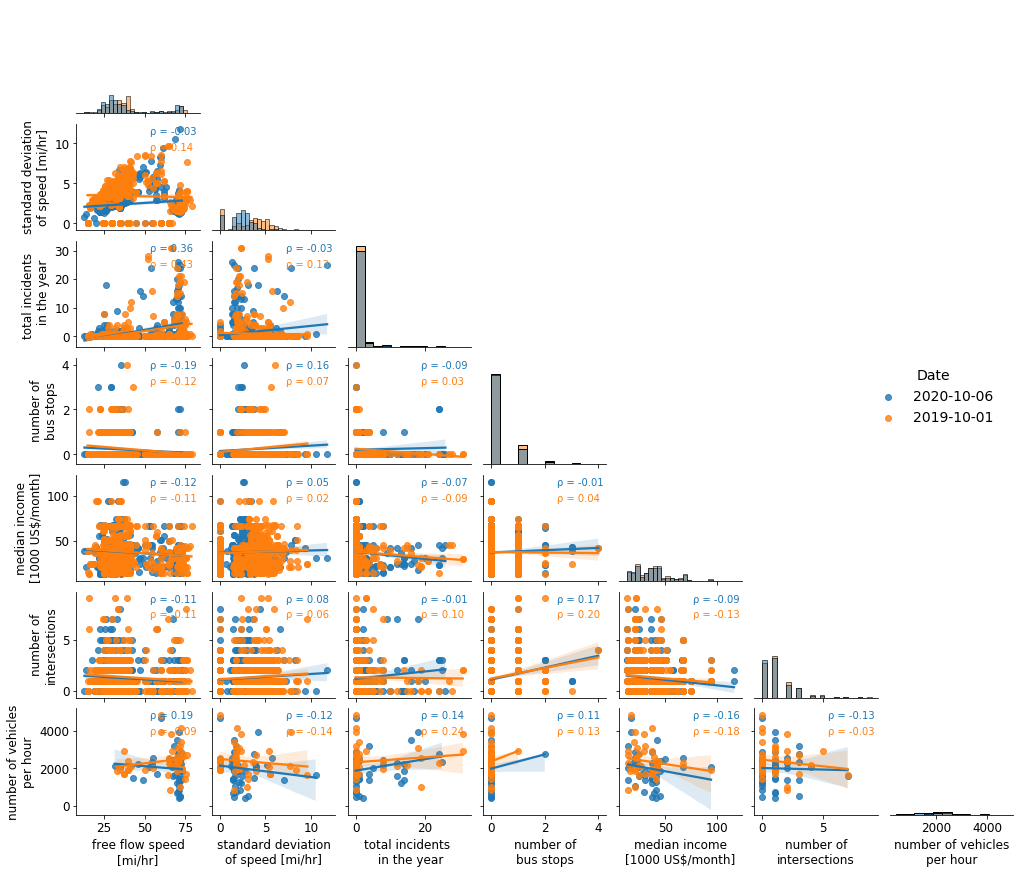

In [9]:
dates = ['2019-10-01','2020-10-06']

summary_table_links_dfs = {}

for date in dates:
    summary_table_links_dfs[date] = pd.read_csv(isl.dirs['output_folder'] + 'network-data/links/'
                          + str(date) + '-fresno-link-data.csv',
                          sep=',', encoding='utf-8')

    summary_table_links_dfs[date]['free_flow_speed'] \
        = tt_factor*summary_table_links_dfs[date]['length']/summary_table_links_dfs[date]['tf_inrix']

    # summary_table_links_df = pd.DataFrame(
    #     preprocessing.MinMaxScaler().fit_transform(summary_table_links_raw_df[features_dict.keys()].values))

    summary_table_links_dfs[date].insert(0, 'date', date)


summary_table_links_df = pd.concat(summary_table_links_dfs.values())

summary_table_links_df.reset_index(inplace=True)

scatter_fig = isl.descriptive_statistics.scatter_plots_features(
    links_df= summary_table_links_df[summary_table_links_df.link_type == 'LWRLK'],
    hue = 'date',
    features = {'free_flow_speed': 'free flow speed\n[mi/hr]',
                'speed_sd': 'standard deviation\nof speed [mi/hr]',
                # 'speed_avg': 'average speed \n[mi/hr]',
                'incidents': 'total incidents \n in the year',
                'bus_stops': 'number of\nbus stops',
                'median_inc': 'median income\n[1000 US$/month]',
                'intersections': 'number of\nintersections', 
                'counts': 'traffic flow\n[veh/hour]'},
    normalized = False,
    folder = isl.config.dirs['output_folder'] + 'plots/',
    filename = 'features_correlations_plot_years.pdf'
)

plt.show()